In [1]:
#!/usr/bin/env python3
import pandas
import lz4.frame
import gzip
import io
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import datetime
import matplotlib.pyplot as plt

from glob import glob
from plumbum.cmd import rm

In [2]:
def load_data(filename, filter_initial=True):
    df = pq.read_table(filename).to_pandas()
    if filter_initial:
        df = df[df['Event Type'] != 'Initial']
        return df

def get_second_data(df, current_second):
    time = sec2string(current_second)
    return df.loc[df['Event Time'].values == time]

def get_minute_data(df, current_minute):
    time = min2string(current_minute)
    next_time = min2string(current_minute + 1)
    return df.loc[(df['Event Time'].values >= time) & (df['Event Time'].values < next_time)]

In [3]:
def sec2string(sec):
    m, s = divmod(sec, 60)
    h, m = divmod(m, 60)
    return "%02d:%02d:%02d" %(h, m, s)

def min2string(minute):
    h, m = divmod(minute, 60)
    return "%02d:%02d:00" %(h, m)

In [4]:
def get_avg_price(df_chunk, percent_change, prev_price, when):
    df_chunk = filter_df(df_chunk, event_type='Fill')
    if len(df_chunk) == 0:
        current_avg_price = prev_price
    else:
        if when == 'start':
            current_avg_price = df_chunk.iloc[0, -1]
        elif when == 'end':
            current_avg_price = df_chunk.iloc[-1, -1]
    return current_avg_price

def calc_percent_change(current_price, prev_price):
    try:
        percent_change = (current_price - prev_price) / prev_price
    except:
        percent_change = 0.0    
    return percent_change

In [5]:
def filter_df(df_chunk, side=None, event_type=None, order_type=None):
    if side is not None:
        df_chunk = df_chunk.loc[df_chunk['Side'].values == side]
    if event_type is not None:
        df_chunk = df_chunk.loc[df_chunk['Event Type'].values == event_type]
    if order_type is not None:
        df_chunk = df_chunk.loc[df_chunk['Order Type'].values == order_type]
    return df_chunk 

def get_frequency(df_chunk):
    return len(df_chunk)
             
def get_volume(df_chunk, volume_type=None):
    if volume_type=='filled':
        return sum(df_chunk['Fill Price (USD)'] * df_chunk['Fill Quantity (BTC)'])
    if volume_type=='unfilled':
        return sum(df_chunk['Limit Price (USD)'] * df_chunk['Original Quantity (BTC)'])

def calculate_percentage(value1, value2):
    if value1 == 0.0 and value2 == 0.0:
        percentage = 0.5
    else:
        try:
            percentage = value1 / (value1 + value2 + 1e-6)
        except:
            percentage = None
    return percentage

In [6]:
def one_hot(index, length):
    onehot = [0.]*length
    onehot[index] = 1.
    return onehot
    
def extract_temporal_features(df_chunk):
    year, month, day = df_chunk['Event Date'].values[0].split('-')
    day_of_week = int(datetime.datetime(int(year), int(month), int(day)).weekday())
    hour = int(df_chunk['Event Time'].values[0][0:2])
    month = int(month) - 1
    return one_hot(month, 12), one_hot(day_of_week, 7), one_hot(hour, 24)

In [7]:
def vol_freq(df_chunk, volume_type):
    return get_volume(df_chunk, volume_type=volume_type), get_frequency(df_chunk)

def get_raw_features(df_chunk, side=None):
    x = {}
    x['vol_markets'], x['freq_markets']                   = vol_freq(filter_df(df_chunk, side=side, event_type='Fill', order_type='market'), volume_type='filled')
    x['vol_filled_limits'], x['freq_filled_limits']       = vol_freq(filter_df(df_chunk, side=side, event_type='Fill', order_type='limit'), volume_type='filled')
    x['vol_placed_limits'], x['freq_placed_limits']       = vol_freq(filter_df(df_chunk, side=side, event_type='Place', order_type='limit'), volume_type='unfilled')
    x['vol_cancelled_limits'], x['freq_cancelled_limits'] = vol_freq(filter_df(df_chunk, side=side, event_type='Cancel', order_type='limit'), volume_type='unfilled')  
    return x 

def compute_features(x_buy, x_sell):
    # Buys:
    # -Volume of Filled Markets vs Filled Limits
    # -Volume of Placed Limits vs Filled Limits
    # -Frequency of Filled Markets vs Filled Limits
    # -Frequency of Placed Limits vs Filled Limits

    # Sells:
    # -Volume of Filled Markets vs Filled Limits
    # -Volume of Placed Limited vs Filled Limits
    # -Frequency of Filled Markets vs Filled Limits
    # -Frequency of Placed Limits vs Filled Limits

    # Buys vs Sells:
    # -Volume of Filled Market Sells vs Volume of Filled Market Buys
    # -Volume of Placed Limit Sells vs Volume of Placed Limit Buys
    # -Volume of Cancelled Limit Sells vs Volume Cancelled Limit Buys
    # -Frequency of Filled Market Sells vs Frequency of Filled Market Buys
    # -Frequency of Placed Limit Sells vs Frequency of Placed Limit Buys
    # -Frequency of Cancelled Limit Sells vs Frequency of Cancelled Limit Buys

    features = []
    # Buys:
    features.append(calculate_percentage(x_buy['vol_markets'],        x_buy['vol_filled_limits']))
    features.append(calculate_percentage(x_buy['vol_placed_limits'],  x_buy['vol_filled_limits']))
    features.append(calculate_percentage(x_buy['freq_markets'],       x_buy['freq_filled_limits']))
    features.append(calculate_percentage(x_buy['freq_placed_limits'], x_buy['freq_filled_limits']))

    # Sells:
    features.append(calculate_percentage(x_sell['vol_markets'],        x_sell['vol_filled_limits']))
    features.append(calculate_percentage(x_sell['vol_placed_limits'],  x_sell['vol_filled_limits']))
    features.append(calculate_percentage(x_sell['freq_markets'],       x_sell['freq_filled_limits']))
    features.append(calculate_percentage(x_sell['freq_placed_limits'], x_sell['freq_filled_limits']))

    # Buys vs Sells:
    features.append(calculate_percentage(x_sell['vol_markets'],           x_buy['vol_markets']))
    features.append(calculate_percentage(x_sell['vol_placed_limits'],     x_buy['vol_placed_limits']))
    features.append(calculate_percentage(x_sell['vol_cancelled_limits'],  x_buy['vol_cancelled_limits']))
    features.append(calculate_percentage(x_sell['freq_markets'],          x_buy['freq_markets']))
    features.append(calculate_percentage(x_sell['freq_placed_limits'],    x_buy['freq_placed_limits']))
    features.append(calculate_percentage(x_sell['freq_cancelled_limits'], x_buy['freq_cancelled_limits']))

    return features

In [8]:
def get_all_features(df_chunk, percent_change, prev_price):
  
    # Current price, percent change
    current_price = get_avg_price(df_chunk, percent_change, prev_price, when='end')
    percent_change = calc_percent_change(current_price, prev_price)

    feature_vec = [current_price, percent_change]

    # Order book features
    x_buy  = get_raw_features(df_chunk, side='buy')
    x_sell = get_raw_features(df_chunk, side='sell')
    feature_vec.extend(compute_features(x_buy, x_sell))

    # Temporal features
    month_vec, day_vec, hour_vec = extract_temporal_features(df_chunk)
    feature_vec.extend(month_vec)
    feature_vec.extend(day_vec)
    feature_vec.extend(hour_vec)

    return feature_vec

In [9]:
def write_tmp_parquet(df, outfile):
    outfile = outfile.replace('cboe/parquet_BTCUSD/', 'cboe/parquet_preprocessed_BTCUSD/')
    pq.write_table(pa.Table.from_pandas(df), outfile, compression='snappy')

In [10]:
def preprocess_day(filename, visualize=True, write_parquet=False, verbose=True):
    print(filename)
    df = load_data(filename, filter_initial=True)

    # Initialize previous price
    percent_change=0.0
    prev_price = get_avg_price(df, percent_change=None, prev_price=None, when='start')

    # Compute feature vector for each minute of the day
    all_X = []
    for minute in range(24*60):
        if verbose:
            if minute%100 == 0:
                print('Minutes:', minute)

        # Select one minute of data from order book
        df_chunk = get_minute_data(df, minute)
        if len(df_chunk) == 0: # skip minutes with no data
            continue
    
        # Extract features, X
        X = get_all_features(df_chunk, percent_change, prev_price)
        prev_price = X[0]
        percent_change = X[1]
        #all_X.append(X[1:])
        all_X.append(X)

    #columns = ['current_price','percent_change',
    columns = ['current_price', 'percent_change',
               'buy_vol_mark_vs_fillLim','buy_vol_placeLim_vs_fillLim','buy_freq_mark_vs_fillLim','buy_freq_placeLim_vs_fillLim',
               'sell_vol_mark_vs_fillLim','sell_vol_placeLim_vs_fillLim','sell_freq_mark_vs_fillLim','sell_freq_placeLim_vs_fillLim',
               'vol_markSells_vs_markBuys','vol_placeLimSells_vs_placeLimBuys','vol_CancelLimSells_vs_CancelLimBuys',
               'freq_markSells_vs_markBuys','freq_placeLimSells_vs_placeLimBuys','freq_CancelLimSells_vs_CancelLimBuys',
               'm0','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11',
               'd0','d1','d2','d3','d4','d5','d6',
               'h0','h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11',
               'h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23']
    
    # Convert to pandas DF
    new_df = pandas.DataFrame.from_records(all_X, columns=columns) 
  
    # Compute labels, Y
    new_df = calculate_y(new_df)
  
    # Write DF to tmp file to later be concatenated with all others
    if write_parquet:
        write_tmp_parquet(new_df, filename)

    # Visualize
    if visualize:
        visualize_features(new_df)

    return new_df

In [11]:
def check_number_of_events(df, timesteps, resolution='minute', event_type=None, order_type=None):
  
    # Filter data
    if event_type is not None:
        df = df.loc[df['Event Type'].values == event_type]
    if order_type is not None:
        df = df.loc[df['Order Type'].values == order_type]
  
    chunk_lengths = []
    # Minute resolution
    if resolution == 'minute':
        for minute in range(timesteps):
            chunk_lengths.append(len(get_minute_data(df, minute)))
            if minute%200 == 0:
                print('Minute:', minute)
        
    # Second resolution
    elif resolution == 'second':
        for sec in range(timesteps):
            chunk_lengths.append(len(get_second_data(df, sec)))
            if sec%100 == 0:
                print('Second', sec)

    # Visualize
    plt.figure(figsize=(20,2));
    plt.plot(chunk_lengths);
    plt.figure(figsize=(20,5));
    plt.hist(chunk_lengths, bins=40);

    return chunk_lengths

In [12]:
def calculate_y(new_df):
    new_df['y_percent_change'] = new_df.iloc[:,1]
    new_df['y_percent_change'] = new_df['y_percent_change'].shift(-1)
    new_df = new_df[:-1]
    return new_df

In [13]:
def visualize_features(df):
    for column_idx in range(16):
        title = df.columns[column_idx]
        df.plot(y = column_idx, figsize=(20,2), title=title)

In [14]:
# # Visualize events
# event_type = "Fill"
# order_type = None
# resolution = 'minute'
# timesteps = 24*60

# chunk_lengths = check_number_of_events(df, timesteps=timesteps, resolution=resolution,
#                                        event_type=event_type, order_type=order_type)

In [ ]:
# # # Preprocess all files
# count = 0
# filenames = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))
# filenames.reverse()
# for day in range(len(filenames)):
#     filename = filenames[day]
#     new_df = preprocess_day(filename, write_parquet=True, visualize=False, verbose=False)
#     count += 1
#     print(count, '/', len(filenames))

cboe/parquet_BTCUSD/BTCUSD_order_book_20180220.parquet
1 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180219.parquet
2 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180218.parquet
3 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180217.parquet
4 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180216.parquet
5 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180215.parquet
6 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180214.parquet
7 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180213.parquet
8 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180212.parquet
9 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180211.parquet
10 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180210.parquet
11 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180209.parquet
12 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180208.parquet
13 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180207.parquet
14 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180206.parquet
15 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20180205.pa

128 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171015.parquet
129 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171014.parquet
130 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171013.parquet
131 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171012.parquet
132 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171011.parquet
133 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171010.parquet
134 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171009.parquet
135 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171008.parquet
136 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171007.parquet
137 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171006.parquet
138 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171005.parquet
139 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171004.parquet
140 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171003.parquet
141 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171002.parquet
142 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20171001.parquet
143 / 867
cboe/parquet_BT

255 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170610.parquet
256 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170609.parquet
257 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170608.parquet
258 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170607.parquet
259 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170606.parquet
260 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170605.parquet
261 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170604.parquet
262 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170603.parquet
263 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170602.parquet
264 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170601.parquet
265 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170531.parquet
266 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170530.parquet
267 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170529.parquet
268 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170528.parquet
269 / 867
cboe/parquet_BTCUSD/BTCUSD_order_book_20170527.parquet
270 / 867
cboe/parquet_BT

cboe/parquet_BTCUSD/BTCUSD_order_book_20180220.parquet
Minutes: 0
Minutes: 100
Minutes: 200
Minutes: 300
Minutes: 400
Minutes: 500
Minutes: 600
Minutes: 700
Minutes: 800
Minutes: 900
Minutes: 1000
Minutes: 1100
Minutes: 1200
Minutes: 1300
Minutes: 1400
1 / 867


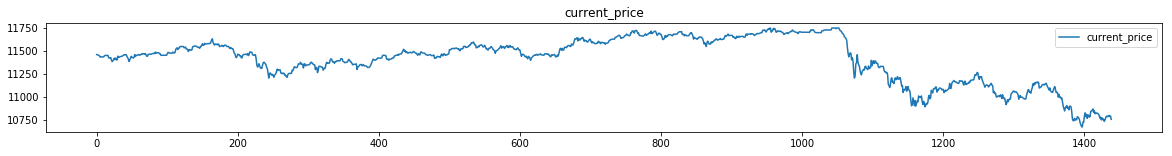

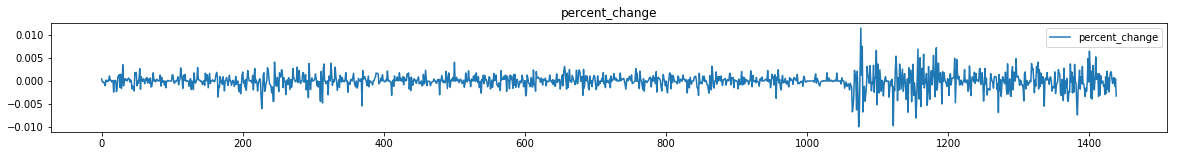

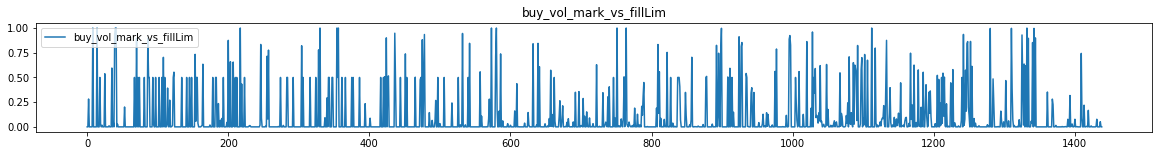

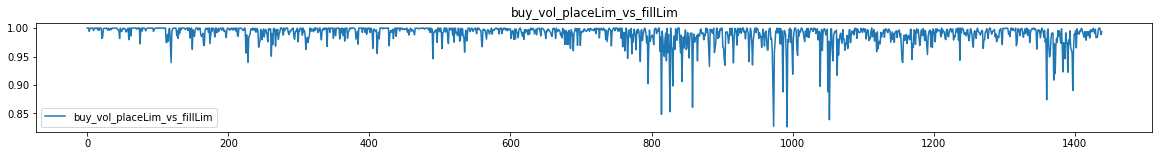

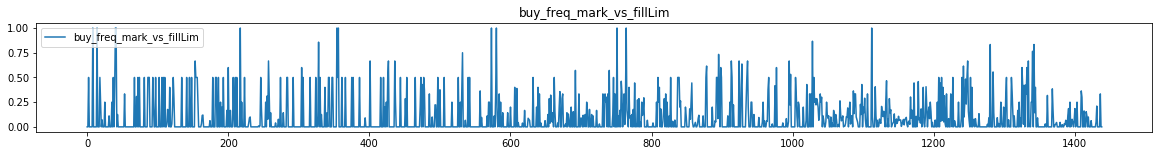

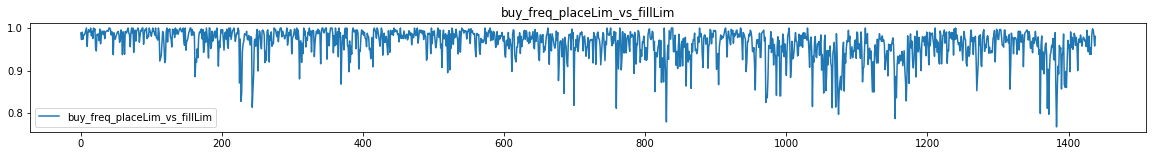

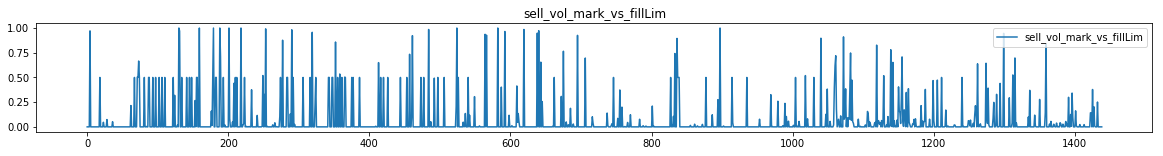

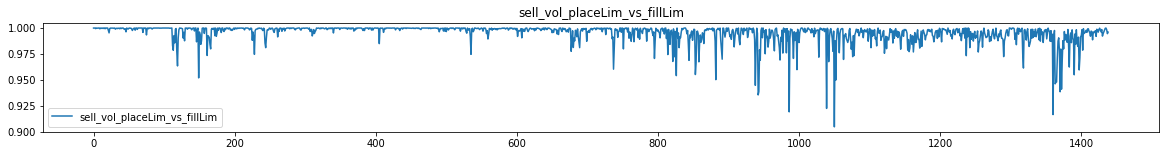

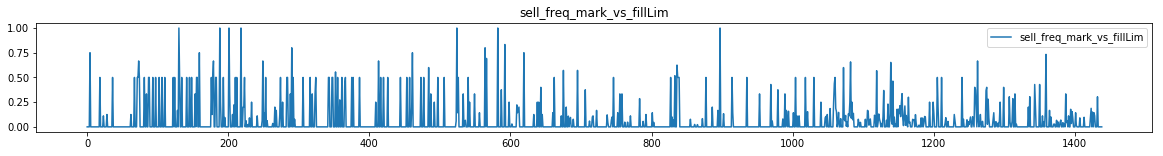

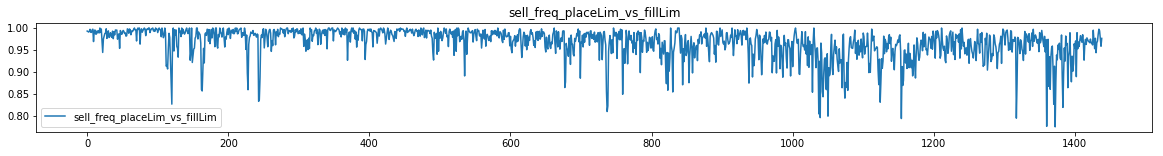

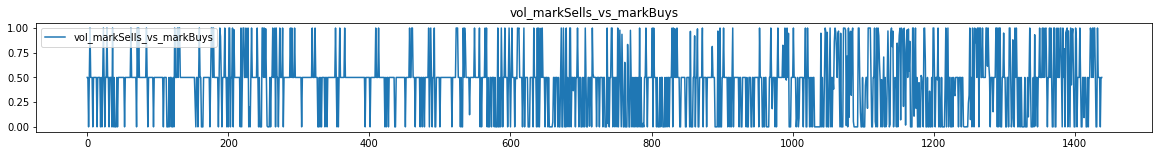

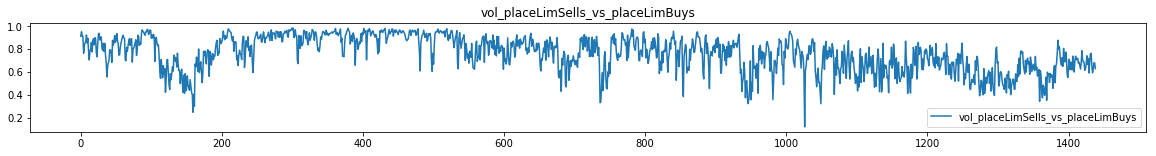

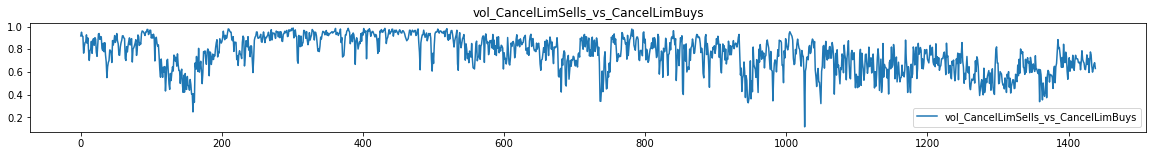

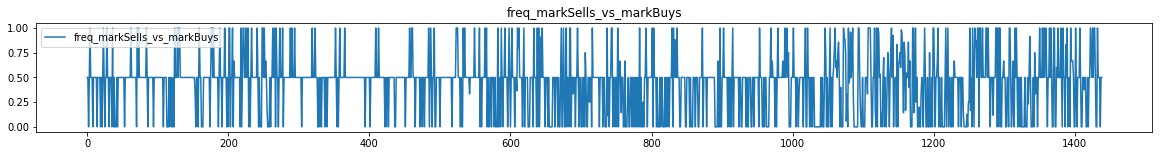

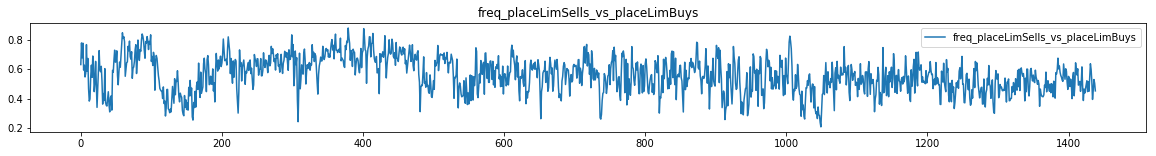

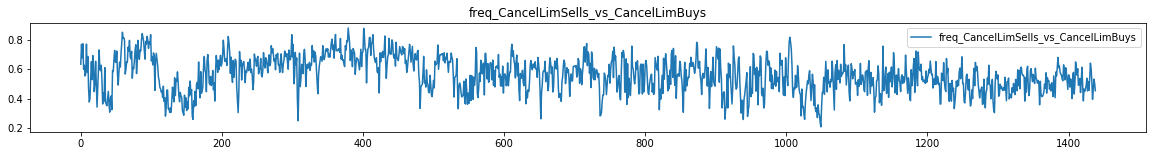

In [16]:
# # Preprocess all files
count = 0
filenames = sorted(glob('cboe/parquet_BTCUSD/*.parquet'))
filenames.reverse()
filename = filenames[0]
new_df = preprocess_day(filename, write_parquet=False, visualize=True, verbose=True)
count += 1
print(count, '/', len(filenames))

In [35]:
columns = ['current_price', 'percent_change',
           'buy_vol_mark_vs_fillLim',
           'buy_vol_placeLim_vs_fillLim',
           'buy_freq_mark_vs_fillLim',
           'buy_freq_placeLim_vs_fillLim',
           'sell_vol_mark_vs_fillLim','sell_vol_placeLim_vs_fillLim','sell_freq_mark_vs_fillLim','sell_freq_placeLim_vs_fillLim',
           'vol_markSells_vs_markBuys',
           'vol_placeLimSells_vs_placeLimBuys',
           'vol_CancelLimSells_vs_CancelLimBuys',
           'freq_markSells_vs_markBuys',
           'freq_placeLimSells_vs_placeLimBuys',
           'freq_CancelLimSells_vs_CancelLimBuys']

In [36]:
titles = ['Current Price (USD)', 'Percent Change',
           'Volume of Market Buys vs. Filled Limit Buys',
           'Volume of Placed Limit Buys vs. Filled Limit Buys',
           'Frequency of Market Buys vs. Filled Limit Buys',
           'Frequency of Placed Limit Buys vs. Filled Limit Buys',
           'skip','skip','skip','skip',
           'Volume of Market Sells vs. Market Buys',
           'Volume of Placed Limit Sells vs. Placed Limit Buys',
           'Volume of Cancelled Limit Sells vs. Cancelled Limit Buys',
           'Frequency of Market Sells vs. Market Buys',
           'Frequency of Placed Limit Sells vs. Placed Limit Buys',
           'Frequency of Cancelled Limit Sells vs. Cancelled Limit Buys']

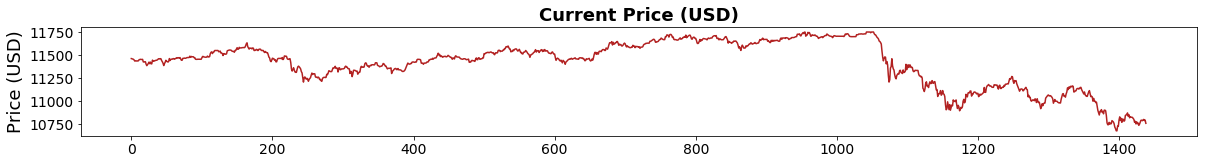

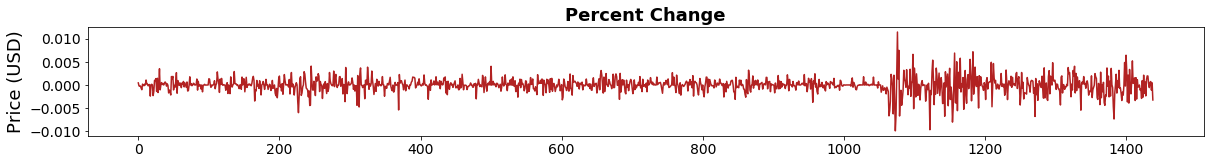

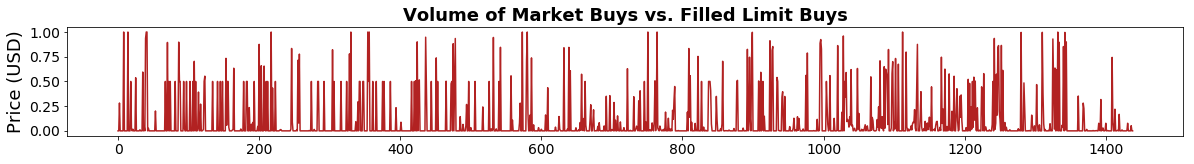

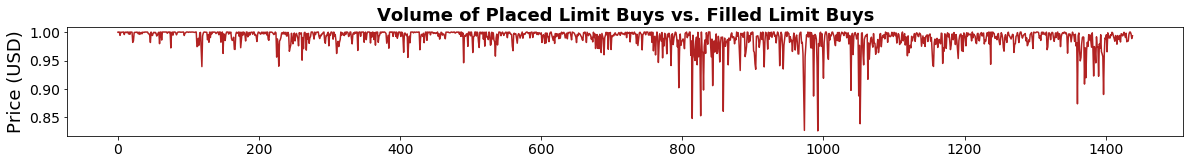

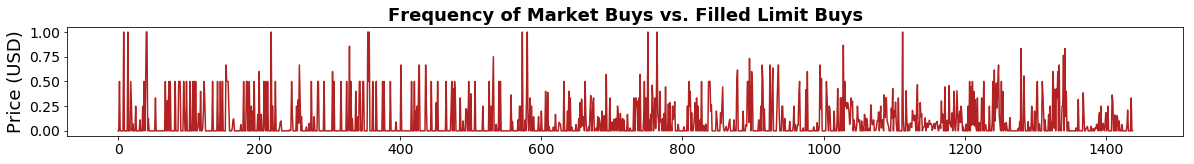

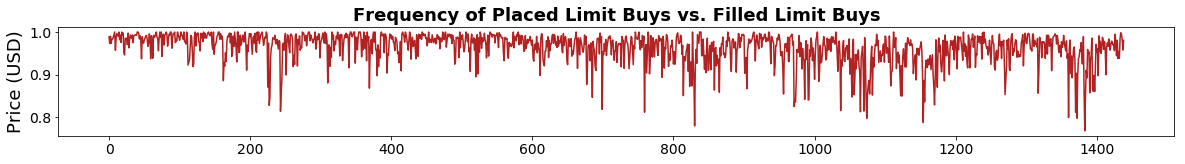

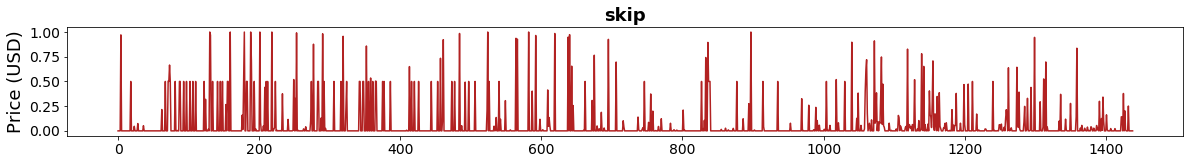

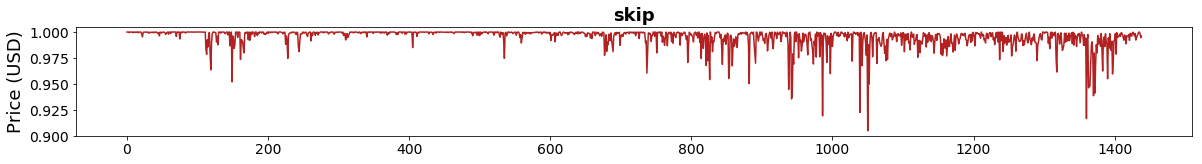

In [72]:
for column_idx in range(0,8):
  vals = new_df[columns[column_idx]]
  title = titles[column_idx]
  new_df.plot(y = column_idx, figsize=(20,2), title=title, fontsize=14, legend=False, color='firebrick')
  #plt.xlabel('Minutes', fontsize=18)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.title(title, fontsize=18, fontweight='bold')

In [45]:
new_df['current_price']

0       11462.060000
1       11459.732334
2       11456.670000
3       11454.210000
4       11446.500000
5       11434.760000
6       11436.800000
7       11437.050000
8       11435.010000
9       11436.940000
10      11437.050000
11      11449.300000
12      11451.870000
13      11454.180000
14      11452.010000
15      11452.008562
16      11453.210000
17      11425.610000
18      11425.610000
19      11427.310000
20      11427.330000
21      11401.000000
22      11385.000000
23      11396.150000
24      11407.320000
25      11423.070000
26      11407.110000
27      11423.710000
28      11405.000000
29      11405.000000
            ...     
1409    10846.260000
1410    10850.000000
1411    10855.880000
1412    10872.490000
1413    10835.882436
1414    10853.060000
1415    10819.890000
1416    10832.210000
1417    10826.910000
1418    10824.660000
1419    10824.610000
1420    10812.490000
1421    10803.000000
1422    10771.530000
1423    10781.670000
1424    10753.180000
1425    10776